In [1]:
# Decide if you want to train DeBerta coupled models or not (in thatcase, just finetune the fc)
FREEZE_BACKBONE = True

# Paths to retrieve data
DATASET_PATH  = "Augmented Datasets/"
FEVER_PLUS_PATH = 'tommasobonomo/sem_augmented_fever_nli'
ADVERSARIAL_FEVER_PATH = "iperbole/adversarial_fever_nli" #'https://huggingface.co/datasets/iperbole/adversarial_fever_nli'


# Twinned model 

### Load and process data

In [3]:
# Ensure all jsonl files for augmented datasets are here
import os
import zipfile

# Datasets needed:
file_paths = [
    DATASET_PATH+"fever_train_wr",
    DATASET_PATH+"fever_validation_wr",
    DATASET_PATH+"fever_test_wr",
    DATASET_PATH+"fever_train_syn",
    DATASET_PATH+"fever_validation_syn",
    DATASET_PATH+"fever_test_syn"
]


for path in file_paths:
    if not os.path.exists(path+'.jsonl'):
        # Unzip if not exist already
        with zipfile.ZipFile(path+'.zip', 'r') as zip:
            zip.extractall(DATASET_PATH)
            print(f"{path} extracted to {DATASET_PATH}")


Augmented Datasets/fever_test_wr extracted to Augmented Datasets/


In [7]:
# load and assemble datasets
from datasets import Dataset
import json
import pandas as pd

# Function to load .jsonl dataset
def load_jsonl_datasets(premise_file_path, hypothesis_file_path):
    #data = {'premise' [], 'hypothesis' [], 'label' []}
    premises = []
    hypotheses = []
    labels = []

    # Load premise and labels
    with open(premise_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            premises.append(entry['augmented_premise'])
            labels.append(entry['label'])

    # Load hypothesis
    with open(hypothesis_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            hypotheses.append(entry['augmented_hypothesis'])

    # wr_data = pd.read_json(premise_file_path, lines=True)
    # syn_data = pd.read_json(hypothesis_file_path, lines=True)

    # Convert to Hugging Face Dataset
    data = {'premise': premises, 'hypothesis': hypotheses, 'label': labels}
    #data = {'premise' wr_data['augmented_premise'], 'hypothesis' syn_data['augmented_hypothesis'], 'label' syn_data['label']}
    return Dataset.from_dict(data)


# Load datasets from jsonl files
train_data = load_jsonl_datasets(DATASET_PATH+'fever_train_wr.jsonl', DATASET_PATH+'fever_train_syn.jsonl')
val_data = load_jsonl_datasets(DATASET_PATH+'fever_validation_wr.jsonl', DATASET_PATH+'fever_validation_syn.jsonl')
test_data = load_jsonl_datasets(DATASET_PATH+'fever_test_wr.jsonl', DATASET_PATH+'fever_test_syn.jsonl')


In [27]:
from datasets import Dataset, load_dataset, concatenate_datasets

# Load the dataset
fever_plus = load_dataset(FEVER_PLUS_PATH)

# Map the required fields and convert to Dataset objects
original_train_data = fever_plus['train'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})
original_val_data = fever_plus['validation'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})

# Combine datasets
combined_train_data = concatenate_datasets([original_train_data, train_data])
combined_val_data = concatenate_datasets([original_val_data, val_data])

# Load other test datasets
original_test_data = fever_plus['test'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})
adv_test_data = load_dataset(ADVERSARIAL_FEVER_PATH)['test'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})


Map: 100%|██████████| 337/337 [00:00<00:00, 11021.55 examples/s]


In [28]:
from transformers import DebertaV2Tokenizer

# Function to tokenize and format a single entry
def preprocess_input(entry, tokenizer, prem_max_length=256, hyp_max_length=256):
    label_map = {'ENTAILMENT': 0, 'CONTRADICTION': 1, 'NEUTRAL': 2}
    premise = entry['premise']
    hypothesis = entry['hypothesis']
    label = entry['label']

    inputs1 = tokenizer(premise, hypothesis, truncation=True, padding='max_length', max_length=prem_max_length)
    inputs2 = tokenizer(hypothesis, premise, truncation=True, padding='max_length', max_length=hyp_max_length)
    
    return {
        "input_ids1": inputs1['input_ids'],
        "attention_mask1": inputs1['attention_mask'],
        "input_ids2": inputs2['input_ids'],
        "attention_mask2": inputs2['attention_mask'],
        "labels": label_map[label]
    }

# Load the tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-xsmall')

# Ensure train_data, val_data, and test_data are defined
# Encode datasets
train_dataset = train_data.map(lambda entry: preprocess_input(entry, tokenizer))
val_dataset = val_data.map(lambda entry: preprocess_input(entry, tokenizer))
test_dataset = test_data.map(lambda entry: preprocess_input(entry, tokenizer))

# Load other test datasets
original_test_dataset = original_test_data.map(lambda entry: preprocess_input(entry, tokenizer))
adv_test_dataset = adv_test_data.map(lambda entry: preprocess_input(entry, tokenizer))


Map:   0%|          | 0/51086 [00:00<?, ? examples/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not return

### Model architecture

In [13]:
import torch
import torch.nn as nn
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments


class TwinnedModel(nn.Module):
    def __init__(self, freeze_weights, model_name1='microsoft/deberta-v3-xsmall', model_name2='microsoft/deberta-v3-xsmall', hidden_size=128, num_classes=3):
        super(TwinnedModel, self).__init__()

        # Load pre-trained models
        self.model1 = DebertaV2ForSequenceClassification.from_pretrained(model_name1, num_labels=hidden_size)   # here i do not use num_classes because i want to combine features to input to linear layers
        self.model2 = DebertaV2ForSequenceClassification.from_pretrained(model_name2, num_labels=hidden_size)

        # Freeze the models if fine-tuning is not needed
        for param in self.model1.parameters():
            param.requires_grad = freeze_weights
        for param in self.model2.parameters():
            param.requires_grad = freeze_weights

        # Define a fully connected layer to combine the hidden states
        combined_hidden_size = self.model1.config.hidden_size + self.model2.config.hidden_size
        self.fc = nn.Linear(combined_hidden_size, num_classes)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):
        # Get outputs from both models (hidden states instead of logits)
        outputs1 = self.model1(input_ids1, attention_mask=attention_mask1, output_hidden_states=True)
        outputs2 = self.model2(input_ids2, attention_mask=attention_mask2, output_hidden_states=True)

        # Get the last hidden state (hidden_states[-1])
        hidden_state1 = outputs1.hidden_states[-1][:, 0, :]  # [CLS] token representation
        hidden_state2 = outputs2.hidden_states[-1][:, 0, :]  # [CLS] token representation

        # Concatenate the hidden states
        combined_hidden = torch.cat((hidden_state1, hidden_state2), dim=1)

        # Pass the combined hidden states through the fully connected layer
        logits = self.fc(combined_hidden)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

### Model training

In [15]:
# Custom data collator
def data_collator(features):
    input_ids1 = torch.tensor([f["input_ids1"] for f in features], dtype=torch.long)
    attention_mask1 = torch.tensor([f["attention_mask1"] for f in features], dtype=torch.long)
    input_ids2 = torch.tensor([f["input_ids2"] for f in features], dtype=torch.long)
    attention_mask2 = torch.tensor([f["attention_mask2"] for f in features], dtype=torch.long)
    labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)

    return {
        "input_ids1": input_ids1,
        "attention_mask1": attention_mask1,
        "input_ids2": input_ids2,
        "attention_mask2": attention_mask2,
        "labels": labels
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,  # Simulate batch size of 8*4=32 but without loading all at once
    per_device_eval_batch_size=1,
    num_train_epochs=1,     # Train ONCE on the original fever and ONCE on the augmented one
    weight_decay=0.01,
    fp16=True,  # Mixed precision training (weight are in float16)
    logging_dir='./logs',
    logging_steps=100,
)

# Initialize the model
model = TwinnedModel(freeze_weights=FREEZE_BACKBONE, hidden_size=128)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
# trainer.evaluate(test_dataset)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▋         | 100/1596 [20:04<5:20:05, 12.84s/it]

{'loss': 0.9376, 'grad_norm': 3.963512420654297, 'learning_rate': 1.87468671679198e-05, 'epoch': 0.06}


 13%|█▎        | 200/1596 [40:48<4:53:39, 12.62s/it]

{'loss': 0.617, 'grad_norm': 5.438436985015869, 'learning_rate': 1.74937343358396e-05, 'epoch': 0.13}


 19%|█▉        | 300/1596 [1:01:34<4:27:06, 12.37s/it]

{'loss': 0.4656, 'grad_norm': 3.1238796710968018, 'learning_rate': 1.62406015037594e-05, 'epoch': 0.19}


 25%|██▌       | 400/1596 [1:22:12<4:06:57, 12.39s/it]

{'loss': 0.4491, 'grad_norm': 4.590611457824707, 'learning_rate': 1.49874686716792e-05, 'epoch': 0.25}


 31%|███▏      | 500/1596 [1:42:53<3:42:16, 12.17s/it]

{'loss': 0.4248, 'grad_norm': 4.393791675567627, 'learning_rate': 1.3734335839598997e-05, 'epoch': 0.31}


 38%|███▊      | 600/1596 [2:03:52<3:24:34, 12.32s/it]

{'loss': 0.3911, 'grad_norm': 4.657990455627441, 'learning_rate': 1.2481203007518798e-05, 'epoch': 0.38}


 44%|████▍     | 700/1596 [2:24:54<3:12:43, 12.91s/it]

{'loss': 0.4078, 'grad_norm': 4.756745338439941, 'learning_rate': 1.1228070175438597e-05, 'epoch': 0.44}


 50%|█████     | 800/1596 [2:45:50<2:46:35, 12.56s/it]

{'loss': 0.3975, 'grad_norm': 2.8634841442108154, 'learning_rate': 9.974937343358396e-06, 'epoch': 0.5}


 56%|█████▋    | 900/1596 [3:06:21<2:23:03, 12.33s/it]

{'loss': 0.3908, 'grad_norm': 5.399654865264893, 'learning_rate': 8.721804511278195e-06, 'epoch': 0.56}


 63%|██████▎   | 1000/1596 [3:27:12<2:07:58, 12.88s/it]

{'loss': 0.3984, 'grad_norm': 5.648049831390381, 'learning_rate': 7.468671679197995e-06, 'epoch': 0.63}


 69%|██████▉   | 1100/1596 [3:48:13<1:41:18, 12.26s/it]

{'loss': 0.3847, 'grad_norm': 4.5940937995910645, 'learning_rate': 6.215538847117794e-06, 'epoch': 0.69}


 75%|███████▌  | 1200/1596 [4:09:00<1:22:44, 12.54s/it]

{'loss': 0.3692, 'grad_norm': 5.785048961639404, 'learning_rate': 4.962406015037594e-06, 'epoch': 0.75}


 81%|████████▏ | 1300/1596 [4:29:27<59:32, 12.07s/it]  

{'loss': 0.3766, 'grad_norm': 5.748976707458496, 'learning_rate': 3.7092731829573934e-06, 'epoch': 0.81}


 88%|████████▊ | 1400/1596 [4:50:12<38:18, 11.73s/it]  

{'loss': 0.3918, 'grad_norm': 6.313568115234375, 'learning_rate': 2.456140350877193e-06, 'epoch': 0.88}


 94%|█████████▍| 1500/1596 [5:10:36<19:50, 12.40s/it]

{'loss': 0.3804, 'grad_norm': 3.3879973888397217, 'learning_rate': 1.2030075187969925e-06, 'epoch': 0.94}


                                                     
100%|██████████| 1596/1596 [5:32:55<00:00, 12.52s/it]

{'eval_loss': 0.7198577523231506, 'eval_runtime': 151.8563, 'eval_samples_per_second': 15.067, 'eval_steps_per_second': 15.067, 'epoch': 1.0}
{'train_runtime': 19975.0687, 'train_samples_per_second': 2.557, 'train_steps_per_second': 0.08, 'train_loss': 0.44687119342928244, 'epoch': 1.0}


TrainOutput(global_step=1596, training_loss=0.44687119342928244, metrics={'train_runtime': 19975.0687, 'train_samples_per_second': 2.557, 'train_steps_per_second': 0.08, 'total_flos': 0.0, 'train_loss': 0.44687119342928244, 'epoch': 0.9996868149076104})

In [30]:
# # Save model and tokenizer (not currently possible due to being a custom architecture)
# model.save_pretrained('./saved_model')
# tokenizer.save_pretrained('./saved_model')

### Model testing

100%|██████████| 2287/2287 [02:34<00:00, 14.82it/s]


F1 Score on the test set: 0.7234901183618477


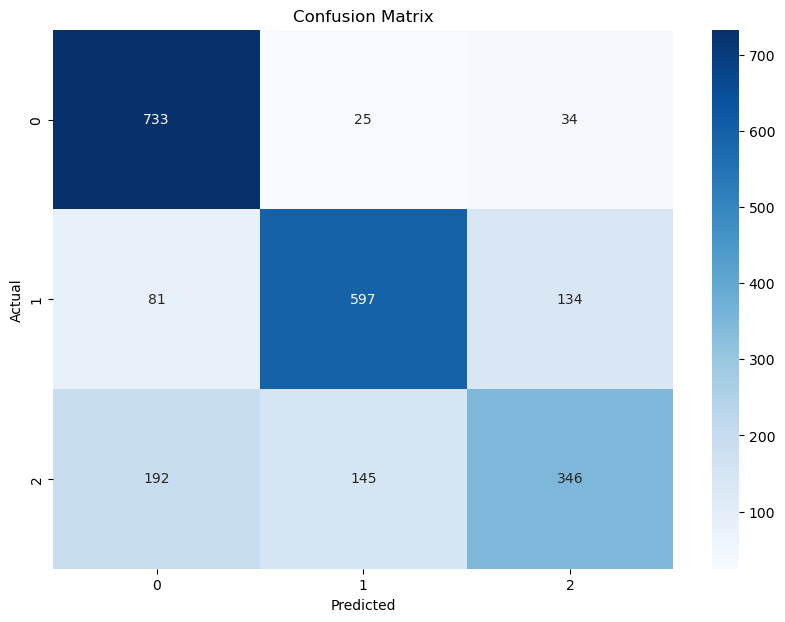

Confusion matrix saved to ./results/confusion_matrix.png


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/fever_confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")


2984it [05:36,  8.86it/s]                           


F1 Score on the test set: 0.7253852663391612


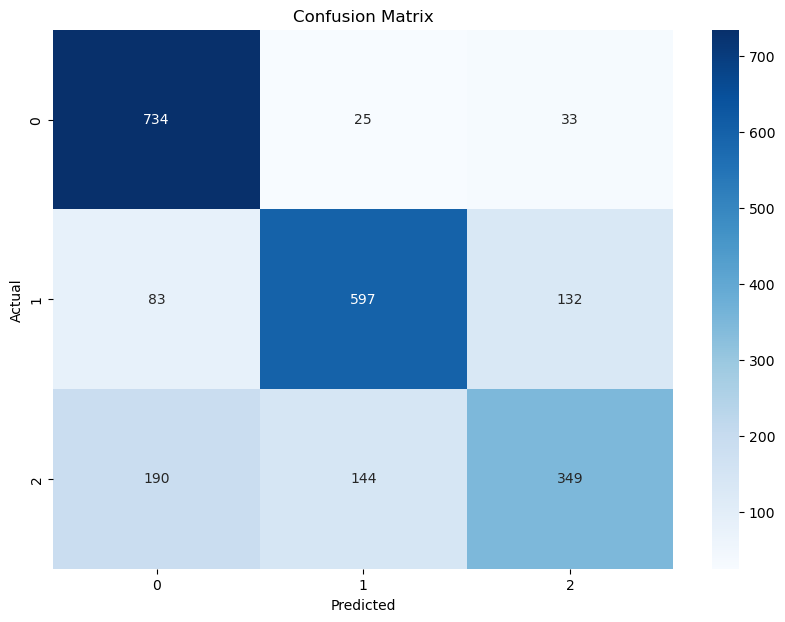

Confusion matrix saved to ./results/confusion_matrix.png


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(original_test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/augmentedfever_confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")


100%|██████████| 337/337 [00:20<00:00, 16.68it/s]


F1 Score on the test set: 0.5674093139340208


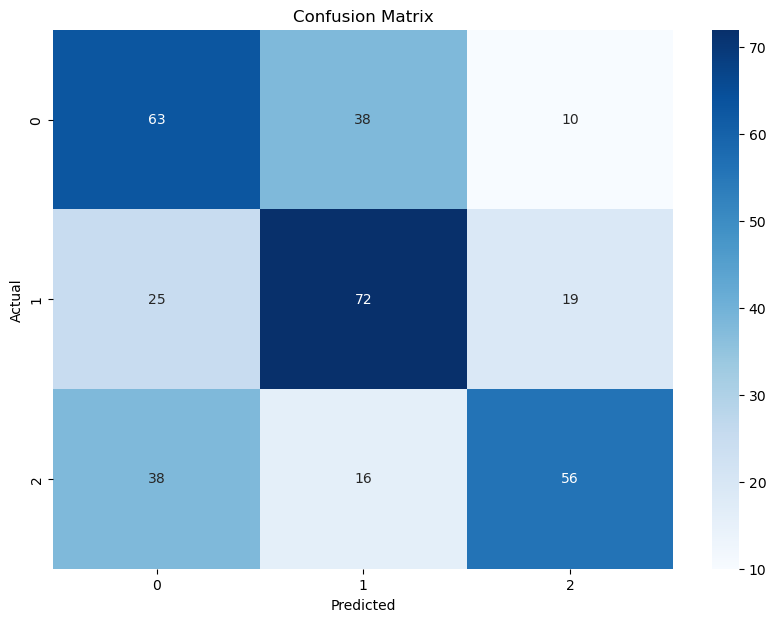

Confusion matrix saved to ./results/confusion_matrix.png


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(adv_test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/advfever_confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")
